In [47]:
import copy
import sys

import scipy.ndimage

sys.path.append("mturk2_code/sim")
import perceptual_rl
import numpy as np
from matplotlib import pyplot as plt
import torch
import pickle
import pandas as pd
from sklearn.mixture import GaussianMixture
import scipy

In [48]:
MODE = "GRU"
fit = "Yuri"
space = "TY"
subjects = ["Yuri"]

TRAIN_TRIALS = 5000
with open("/home/bizon/Projects/mturk2/mturk2_code/saved_data/out_models/"+ fit + "_test_16_1000_5000_GRU.pkl", "rb") as f:
    rnn = pickle.load(f) 

In [49]:
# test sequence head on new instances
c, s = torch.meshgrid([torch.arange(36), torch.arange(36)])
c = c.flatten()
s = s.flatten()
options = torch.stack([c, s], dim=1).unsqueeze(0).unsqueeze(1).tile((1, len(subjects), 1, 1)) # all options on batch

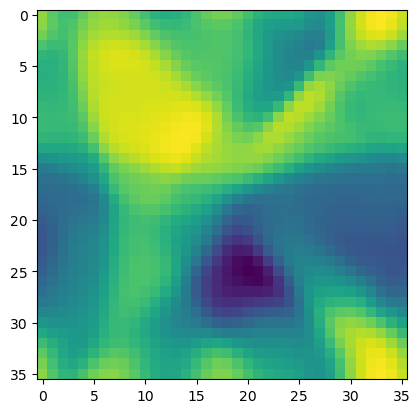

In [50]:
test = rnn.clone()
start_from = 0
if MODE == "nt":
    logits = test.predict(options, torch.tensor([start_from]))
else:
    logits = test.predict(options, None, use_stored_hidden=False)
logits = logits.cpu().detach().numpy()
init_logits = logits.reshape((len(subjects), 36, 36))[0]
plt.imshow(init_logits)

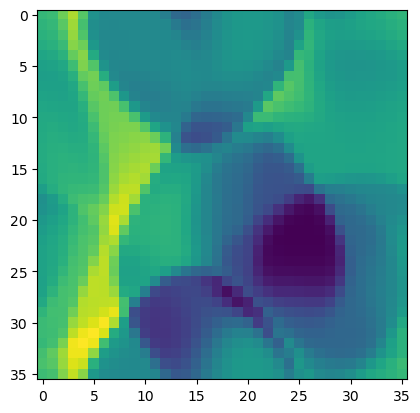

In [54]:
test = rnn.clone()
# run as many trials as we want through model
data = []
for s in subjects:
    subject_trials = "../saved_data/all_" + s + ".csv"
    d = pd.read_csv(subject_trials, sep="\t").head(1000)
    data.append(d)
test.fit(data, epochs=1)
start_from = TRAIN_TRIALS
if MODE == "nt":
    logits = test.predict(options, torch.tensor([start_from]))
else:
    logits = test.predict(options, None, use_stored_hidden=True)
logits = logits.cpu().detach().numpy()
final_logits = logits.reshape((len(subjects), 36, 36))[:1].mean(axis=0)
plt.imshow(final_logits)

[0 1 2 3]


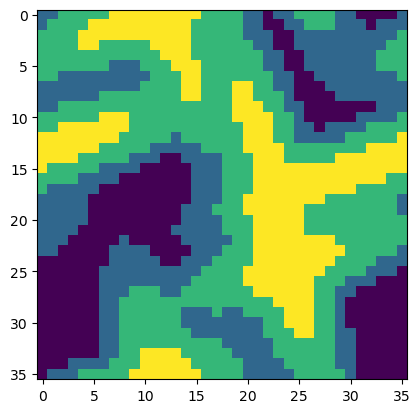

In [8]:
reward_map = pd.read_csv("../../data/reward_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
plt.imshow(reward_map)
plt.savefig("../saved_data/out_rl_figs/reward_map_" + space + ".svg")
print(np.unique(reward_map))

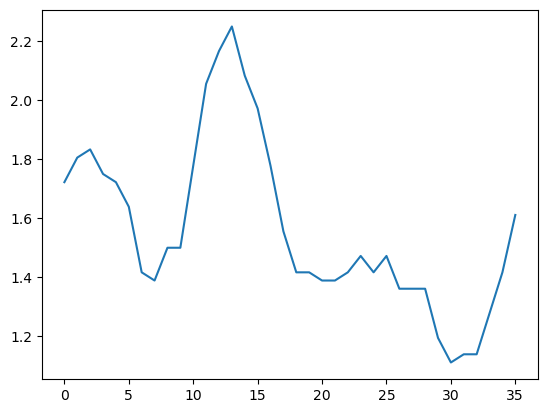

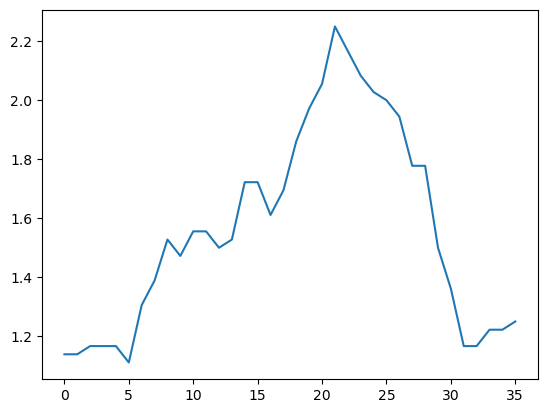

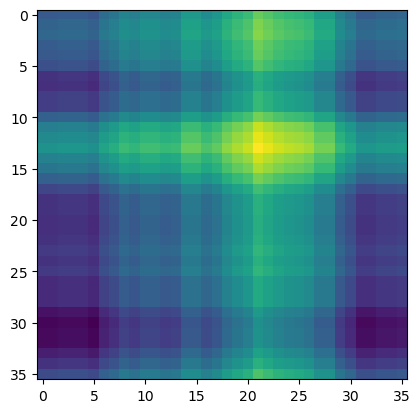

In [9]:
# compute marginal
c_marg = np.mean(reward_map, axis=1)[:, None]
s_marg = np.mean(reward_map, axis=0)[:, None]
idp_space = (c_marg + s_marg.T) / 2
fig1, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
ax1.plot(c_marg)
ax2.plot(s_marg)
ax3.imshow(idp_space)
fig1.savefig("../saved_data/out_rl_figs/color_marginal_" + space + ".svg")
fig2.savefig("../saved_data/out_rl_figs/shape_marginal_" + space + ".svg")
fig3.savefig("../saved_data/out_rl_figs/independent_map_" + space + ".svg")

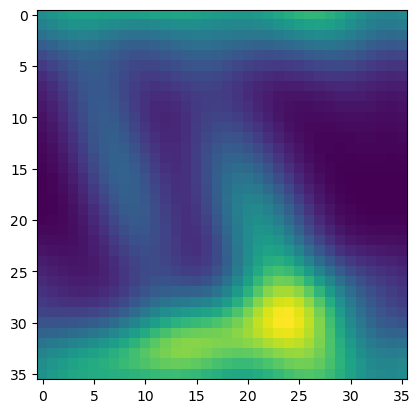

In [30]:
freq_map = pd.read_csv("../../data/freq_space_" + space + ".csv").iloc[:, 0].values.reshape((36, 36)).T
plt.imshow(freq_map)
plt.savefig("../saved_data/out_rl_figs/freq_space_" + space + ".svg")


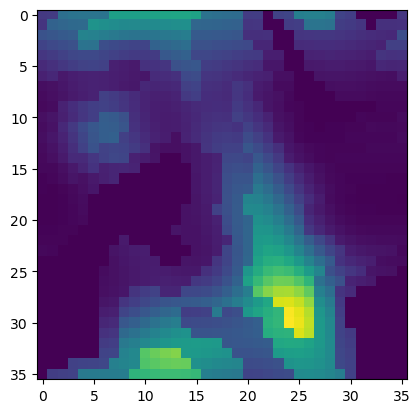

In [11]:
plt.imshow(freq_map * reward_map)
plt.savefig("../saved_data/out_rl_figs/combined_space_" + space + ".svg")

[-0.6756945  0.         1.         2.218945 ]


<BarContainer object of 4 artists>

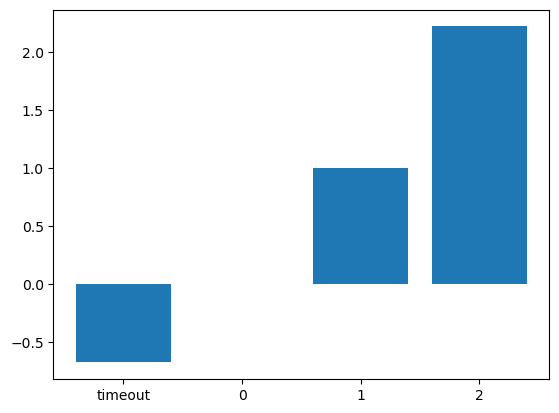

In [12]:
# how rewarding are the different stim levels to yuri relative to one juice pump? (R=2)
subjective_reward = []
for rlevel in [0, 1, 2, 3]:
    rind = reward_map == rlevel
    # f_given_r = freq_map[rind]
    subjective_reward.append(np.mean(final_logits[rind]))
subjective_reward = np.array(subjective_reward)
final_logits = final_logits - subjective_reward[1]
subjective_reward = subjective_reward - subjective_reward[1]
final_logits /= subjective_reward[2]
subjective_reward /= subjective_reward[2]

print(subjective_reward)
plt.bar(["timeout", "0", "1", "2"], subjective_reward)

3.9707526207026013e-16
0.65


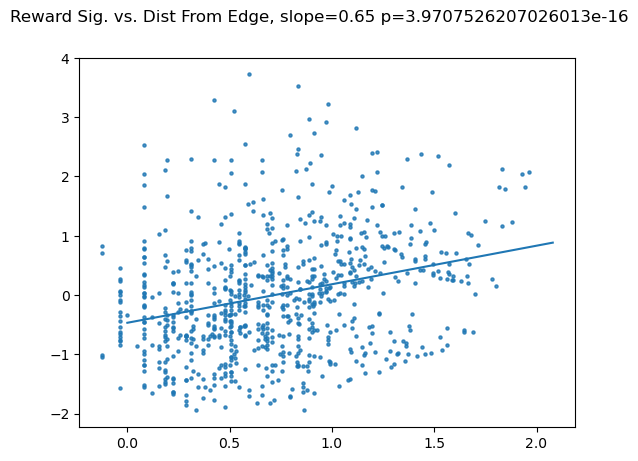

In [21]:
# If cognitive model, reward assigned to center of cluster should be higher than that assigned to edge of cluster 
# get matrix of distances to lower reward boundary 
import copy
dist_from_bound = []
subjrs = []
fig, ax = plt.subplots(1)
for r in [1, 2]:
    bound = copy.copy(reward_map)
    bound[bound < r] = 0
    # plt.imshow(bound)
    edge = np.diff(bound, axis=0, prepend=0) + np.diff(bound, axis=1, prepend=0) != 0
    higher_ind = bound > r
    higher_bound = np.zeros_like(bound)
    higher_bound[higher_ind] = 1
    higher_edge = np.diff(higher_bound, axis=0, prepend=0) + np.diff(higher_bound, axis=1, prepend=0) != 0
    edge[higher_edge] = 0.
    bound[higher_ind] = 0.
    # eliminate prepend edge since in polar space
    reward_coords = np.stack(np.nonzero(bound), axis=1)
    edge_coords = np.stack(np.nonzero(edge), axis=1).astype(float) # edge coords to float
    # get distance to each option from each edge vectors .
    dists = scipy.spatial.distance.cdist(reward_coords.astype(float), edge_coords.astype(float)) # shape <rc, edge> euclidian. 
    # get minimum available edges distance for each cocoredinated 
    min_dists = np.mean(np.sort(dists, axis=1)[:, :5], axis=1)
    subj_r = (final_logits)[reward_coords[:, 0], reward_coords[:, 1]]
    subj_r -= subj_r.mean()
    subj_r /= subj_r.std()
    dist_from_bound.append(min_dists)
    subjrs.append(subj_r)
dist_from_bound = np.concatenate(dist_from_bound)
subjrs = np.concatenate(subjrs)
ax.scatter(np.log(dist_from_bound), subjrs, s=5, alpha=.8) # test when get data.
res = scipy.stats.linregress(np.log(dist_from_bound), subjrs)
m = np.round(res.slope, 2)
b = res.intercept
p = res.pvalue
y = (np.log(np.arange(8) + 1)) * m + b
ax.plot(np.log(np.arange(8) + 1), y)
print(p)
print(m)
fig.suptitle("Reward Sig. vs. Dist From Edge, slope=" + str(m) + " p=" + str(p))
fig.savefig("../saved_data/out_rl_figs/" + space + "_min_dist_vs_rnnreward.svg")
#plt.imshow(edge)

In [34]:
# let's see how the classes cluster
embed = test.last_hidden[:, :len(subjects), :, :32].detach().cpu().numpy() # 36**2, ndim
embed = embed.reshape((len(subjects), 36*36, 16)).mean(axis=0)
cov = np.cov(embed.T)
eig_val, eig_vec = np.linalg.eig(cov)
proj = eig_vec[:, :2]

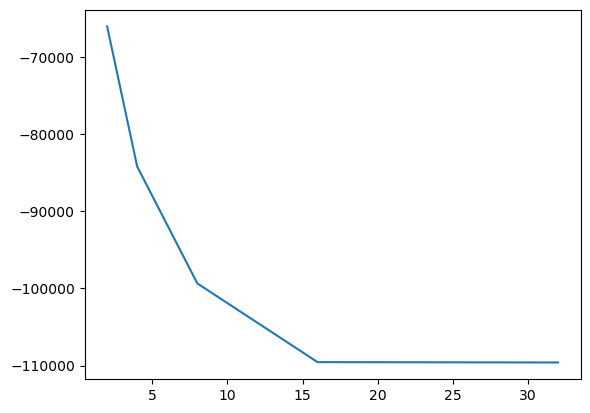

In [35]:
# cluster the data
to_try = [2, 4, 8, 16, 32]
models = [[] for _ in to_try]
scores = [0 for _ in to_try]
iters = 30
for i, n in enumerate(to_try):
        for j in range(iters):
            clust = GaussianMixture(n_components=n)
            clust.fit(embed)
            models[i].append(clust)
            scores[i] += clust.bic(embed)
scores = np.array(scores) / iters
plt.plot(to_try, scores)

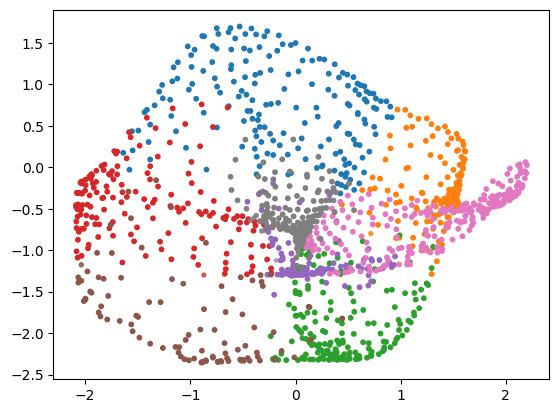

In [36]:
best_model_ind = 2
clust = models[best_model_ind][-3]
assign_probs = clust.predict_proba(embed)
assign = clust.predict(embed)
labels = list(range(to_try[best_model_ind]))
conf = assign_probs[np.arange(len(assign)), assign]
# project data onto pcas and plot 
embed_proj = embed @ proj
for l in labels:
    ind = np.nonzero(assign == l)
    l_conf = conf[ind]
    plt.scatter(embed_proj[ind, 0], embed_proj[ind, 1], alpha=l_conf, s=10 * l_conf)

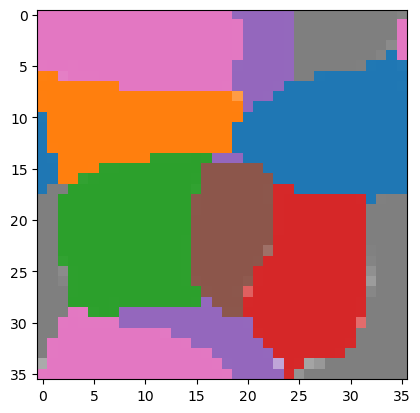

In [37]:
# show on map 
clust_map = assign.reshape((36, 36))
plt.imshow(clust_map, cmap="tab10", vmin=0, vmax=9, alpha=conf.reshape((36, 36)))

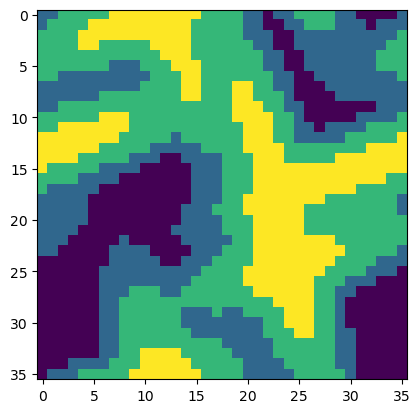

In [38]:
plt.imshow(reward_map)

### Lets try some factor analyis

In [39]:
# let's see how the classes cluster
states = rnn.state_history
states = torch.stack(states).numpy().reshape((-1, rnn.ndims))
cov = np.cov(states.T)
eig_val, eig_vec = np.linalg.eig(cov)

In [40]:
percent_var = eig_val / np.sum(eig_val)
ndim = 0
total = 0
for i, p in enumerate(percent_var):
    total += p
    if total > .9:
        ndim = i
        break
print(ndim, "dims explain", total * 100, "% of variance")

6 dims explain 90.4856801165262 % of variance


[0.16866697 0.65607452 0.30694091 0.21640352 0.43929807 0.08138219
 0.00859124 0.31968455 0.18493716 0.02799667 0.01840944 0.00906269
 0.02604205 0.0895046  0.01121957 0.23232494]


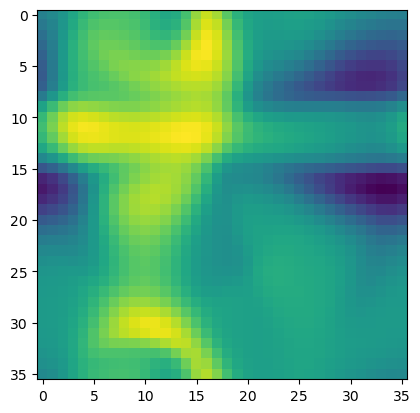

In [42]:
def readout(factor):
    bias = rnn.pred.bias.data.numpy()
    linear_weights = rnn.pred.weight.data.numpy().squeeze()
    linear_weights = linear_weights / np.linalg.norm(linear_weights)
    all_trial = test.last_hidden.detach().cpu().numpy().squeeze()
    proj = eig_vec[:, factor][:, None] # * linear_weights.T
    concordance = proj.T @ linear_weights.squeeze()
    embed = (all_trial @ proj) * concordance + bias
    embed = embed.reshape((36, 36))
    return embed, concordance

# determine readout,
# first factor impact on each predictor
dots = []
for factor in range(16):
    embed, concordance = readout(factor)
    plt.imshow(embed)
    dots.append(concordance)
dots = np.abs(np.concatenate(dots))
print(dots)

<BarContainer object of 16 artists>

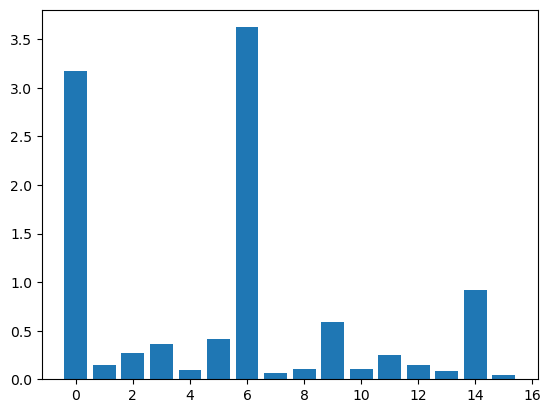

In [44]:
plt.bar(x=np.arange(16), height=percent_var / dots)

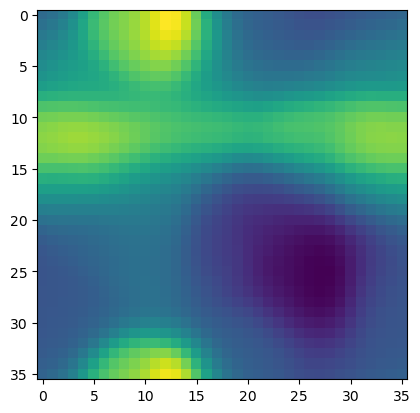

In [52]:
r = readout(2)[0]
plt.imshow(r)

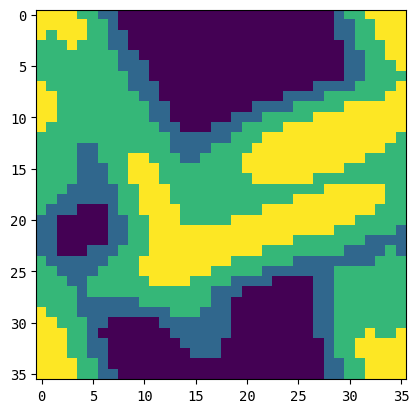

In [104]:
plt.imshow(reward_map)